<a href="https://colab.research.google.com/github/evansemet/Jane-Street-Solutions/blob/main/2019_04_Remote_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install z3-solver
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from z3 import *

     |████████████████████████████████| 33.0 MB 2.2 MB/s 


In [3]:
# information given
fixed = np.array([[2, 0, 0, 0, 7, 1, 8, 3, 6],
                  [0, 0, 0, 0, 0, 0, 0, 2, 0],
                  [0, 0, 5, 0, 0, 5, 4, 0, 2],
                  [0, 0, 0, 1, 0, 0, 5, 0, 1],
                  [8, 3, 3, 0, 1, 0, 2, 4, 4],
                  [3, 0, 4, 0, 0, 3, 0, 0, 0],
                  [6, 0, 2, 3, 0, 0, 5, 0, 0],
                  [0, 4, 0, 0, 0, 0, 0, 0, 0],
                  [7, 2, 7, 3, 1, 0, 0, 0, 3]], dtype=int)

In [4]:
# nice print function for output
def sol_print(solution):
    x= np.ones((3,3))
    groups = np.block([[x*0, x*1, x*2], [x*3, x*4, x*5], [x*6, x*7, x*8]])
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    y = (fixed > 0) + groups*2
    ax = sns.heatmap(y, annot=solution, cbar=False, cmap="tab20", fmt="", linewidths=2, annot_kws={"size": 14})
    ax.axis("off")

In [43]:
# solve function with the help of Z3
def solve():
    print("Solving...")
    start = time.time()
    s = Solver()
    X = np.array(IntVector("x", 9*9), dtype=object).reshape((9, 9))

    # standard rules
    s += [And(e > 0, e <= 9) for _, e in np.ndenumerate(X)]
    s += And([Distinct([e for (i, j), e in np.ndenumerate(X) if i == n]) for n in range(9)])
    s += And([Distinct([e for (i, j), e in np.ndenumerate(X) if j == n]) for n in range(9)])
    x = np.ones((3, 3))
    groups = np.block([[x * 0, x * 1, x * 2], [x * 3, x * 4, x * 5], [x * 6, x * 7, x * 8]])
    s += And([Distinct([e for (i, j), e in np.ndenumerate(X) if groups[i, j] == n]) for n in range(9)])

    # remote constraint
    def options(i, j, X, e):
        spots = [(0, -e), (0, e), (e, 0), (-e, 0)]
        return [X[i + x, j + y] for x, y in spots if (i + x >= 0 and i + x < 9 and j + y >= 0 and j + y < 9)]

    s += [Or([a == int(e) for a in options(i, j, X, e)]) for (i, j), e in np.ndenumerate(fixed) if e > 0]

    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
        r = evalu(X)
        sol_print(r)
        sum = np.sum((r[fixed > 0] ** 2))
        print(f"Solution found in {time.time() - start} seconds.")
        print(f"Answer is {sum}.")
    else:
        print(f"Failed in {time.time() - start} seconds.")

Solving...
Solution found in 0.3129255771636963 seconds.
Answer is 1105.


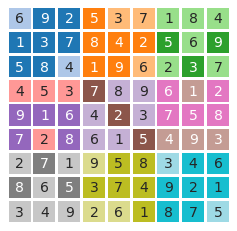

In [44]:
# run code
solve()

In [45]:
# another Z3 solver but this one was 'hard coded' and thus very error prone
# For obvious reasons it's not prefered


def solveHardCoded():
    print("Solving...")
    start = time.time()
    s = Solver()
    X = [[Int("x_%s_%s" % (i + 1, j + 1)) for j in range(9)] for i in range(9)]

    # each cell contains a value in {1, ..., 9}
    s += [And(X[i][j] >= 1, X[i][j] <= 9) for i in range(9) for j in range(9)]
    # each row contains a digit at most once
    s += [Distinct(X[i]) for i in range(9)]
    # each column contains a digit at most once
    s += [Distinct([X[i][j] for i in range(9)]) for j in range(9)]
    # each 3x3 square contains a digit at most once
    s += [Distinct([X[3 * i0 + i][3 * j0 + j] for i in range(3) for j in range(3)]) for i0 in range(3) for j0 in range(3)]

    # first row rules
    s += [Or(X[2][0] == 2, X[0][2] == 2)]
    s += [X[7][4] == 7]
    s += [Or(X[0][4] == 1, X[1][5] == 1, X[0][6] == 1)]
    s += [X[8][6] == 8]
    s += [Or(X[0][4] == 3, X[3][7] == 3)]
    s += [Or(X[0][2] == 6, X[6][8] == 6)]

    # second row rules
    s += [Or(X[1][5] == 2, X[3][7] == 2)]

    # third row rules
    s += [Or(X[7][2] == 5, X[2][7] == 5)]
    s += [Or(X[7][5] == 5, X[2][0] == 5)]
    s += [Or(X[2][2] == 4, X[6][6] == 4)]
    s += [Or(X[0][8] == 2, X[2][6] == 2, X[4][8] == 2)]

    # fourth row rules
    s += [Or(X[2][3] == 1, X[4][3] == 1, X[3][2] == 1, X[3][4] == 1)]
    s += [Or(X[3][1] == 5, X[8][6] == 5)]
    s += [Or(X[2][8] == 1, X[3][7] == 1, X[4][8] == 1)]

    # fifth row rules
    s += [X[4][8] == 8]
    s += [Or(X[1][1] == 3, X[7][1] == 3, X[4][4] == 3)]
    s += [Or(X[1][2] == 3, X[7][2] == 3, X[4][5] == 3)]
    s += [Or(X[3][4] == 1, X[5][4] == 1, X[4][3] == 1, X[4][5] == 1)]
    s += [Or(X[2][6] == 2, X[4][4] == 2, X[4][8] == 2, X[6][6] == 2)]
    s += [Or(X[0][7] == 4, X[4][3] == 4, X[8][7] == 4)]
    s += [Or(X[0][8] == 4, X[4][4] == 4, X[8][8] == 4)]
    
    # sixth row rules
    s += [Or(X[2][0] == 3, X[5][3] == 3, X[8][0] == 3)]
    s += [Or(X[1][2] == 4, X[5][6] == 4)]
    s += [Or(X[5][2] == 3, X[5][8] == 3, X[2][5] == 3, X[8][5] == 3)]

    # seventh row rules
    s += [Or(X[0][0] == 6, X[6][6] == 6)]
    s += [Or(X[6][0] == 2, X[6][4] == 2, X[4][2] == 2, X[8][2] == 2)]
    s += [Or(X[6][0] == 3, X[6][6] == 3, X[3][3] == 3)]
    s += [Or(X[6][1] == 5, X[1][6] == 5)]

    # eighth row rules
    s += [Or(X[7][5] == 4, X[3][1] == 4)]

    # ninth row rules
    s += [Or(X[1][0] == 7, X[8][7] == 7)]
    s += [Or(X[6][1] == 2, X[8][3] == 2)]
    s += [X[1][2] == 7]
    s += [Or(X[8][0] == 3, X[5][3] == 3, X[8][6] == 3)]
    s += [Or(X[8][3] == 1, X[7][4] == 1, X[8][5] == 1)]
    s += [Or(X[8][5] == 3, X[5][8] == 3)]

    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
        r = evalu(X)
        sol_print(r)
        sum = np.sum((r[fixed > 0] ** 2))
        print(f"Solution found in {time.time() - start} seconds.")
        print(f"Answer is {sum}.")
    else:
        print(f"Failed in {time.time() - start} seconds.")

Solving...
Solution found in 0.34926438331604004 seconds.
Answer is 1105.


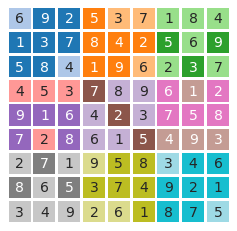

In [46]:
# run code
solveHardCoded()